<a href="https://colab.research.google.com/github/rtnaka/ai-quest2021_assessment/blob/main/PBL01_sample_code_%E6%94%B9%E5%A4%89.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PBL01_需要予測・在庫最適化　サンプルコード

当サンプルコードは、「PBL01_需要予測・在庫最適化のテーマのAI課題（演習④）」において、配布されたファイルを分析し、投稿ファイルを作成するまでの大まかな流れを、ソースコードや実行結果とともに示したものとなっていますので、詳細な分析を行う足がかりとしてご利用ください。

当サンプルコードは、以下のような流れで構成されています。

1. データの読み込み
2. データの整理・概要把握
3. 前処理
4. 特徴量生成
5. モデリング
6. 提出用ファイルの作成

なお、ソースコードは配布ファイルがすべて同じディレクトリ内に存在することを想定しています。

# ライブラリのインポート

In [ ]:
from itertools import product

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.linear_model import LinearRegression

# 1. データの読み込み: pandas.read_csv()

In [ ]:
# Google DriveをColabにマウント
from google.colab import drive
drive.mount('/content/drive')

# ファイルパス
basepath = '/content/drive/MyDrive/AI Quest2021/data/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
sales = pd.read_csv(basepath+'sales_history.csv')
cats = pd.read_csv(basepath+'item_categories.csv')
cat_names = pd.read_csv(basepath+'category_names.csv')
test = pd.read_csv(basepath+'test.csv',index_col=0)
sub = pd.read_csv(basepath+'sample_submission.csv', header=None)

# 2. データの整理、概要把握

### データのマージ(統合): pd.merge(df1, df2)

「sales_history.csv」、「item_category.csv」、「category_names.csv」の3つのテーブルを統合する。

In [ ]:
#商品カテゴリ　→　大カテゴリ/小カテゴリに分割
split_catname = cat_names["商品カテゴリ名"].str.split("-",expand=True)
cat_names = pd.concat([cat_names,split_catname],axis=1)
cat_names.drop("商品カテゴリ名",axis=1,inplace=True)
cat_names.rename(columns={0: '商品大カテゴリ', 1: '商品小カテゴリ'},inplace=True)
cat_names.head()

,商品カテゴリID,商品大カテゴリ,商品小カテゴリ
0,100,映画,DVD
1,110,PCゲーム,通常版
2,120,音楽,その他
3,130,ゲーム,ゲーム機C
4,140,映画,ブルーレイ


In [ ]:
sales = pd.merge(sales, cats, on='商品ID', how='left')
sales = pd.merge(sales, cat_names, on='商品カテゴリID', how='left')

sales.head()

,日付,店舗ID,商品ID,商品価格,売上個数,商品カテゴリID,商品大カテゴリ,商品小カテゴリ
0,2018-01-01,9,1000001,420,1.0,100,映画,DVD
1,2018-01-01,6,1000001,420,1.0,100,映画,DVD
2,2018-01-01,10,1000001,420,1.0,100,映画,DVD
3,2018-01-01,0,1000017,250,1.0,100,映画,DVD
4,2018-01-01,1,1000017,250,1.0,100,映画,DVD


### 「日付」カラムの文字列から「年」「月」の情報を抽出する。: pandas.Series.apply(), str.split()

「日付」カラムの規則性を利用して、より扱いやすい形で情報を抽出する。

In [ ]:
# 「日付」カラムの文字列から、「年」「月」の情報を抽出する
sales['年'] = sales['日付'].apply(lambda x: x.split('-')[0])
sales['月'] = sales['日付'].apply(lambda x: x.split('-')[1])

sales.head()

,日付,店舗ID,商品ID,商品価格,売上個数,商品カテゴリID,商品大カテゴリ,商品小カテゴリ,年,月
0,2018-01-01,9,1000001,420,1.0,100,映画,DVD,2018,01
1,2018-01-01,6,1000001,420,1.0,100,映画,DVD,2018,01
2,2018-01-01,10,1000001,420,1.0,100,映画,DVD,2018,01
3,2018-01-01,0,1000017,250,1.0,100,映画,DVD,2018,01
4,2018-01-01,1,1000017,250,1.0,100,映画,DVD,2018,01


In [ ]:
# 「年」と「月」の全組み合わせを作成する
gp_time = sales.groupby(['年', '月']).count().reset_index()[['年', '月']]
gp_time.head()

,年,月
0,2018,01
1,2018,02
2,2018,03
3,2018,04
4,2018,05


In [ ]:
# カラム名「月ブロック」として、通し番号をつける
gp_time['月ブロック'] = list(range(len(gp_time)))

# testデータ用に、評価対象期間である2019年12月(月ブロック: 23)のレコードを追加する
gp_time = gp_time.append({
    '月ブロック': 23,
    '年': '2019',
    '月': '12'
}, ignore_index=True)

gp_time.head()

,年,月,月ブロック
0,2018,01,0
1,2018,02,1
2,2018,03,2
3,2018,04,3
4,2018,05,4


In [ ]:
# 「月ブロック」カラムをsalesに統合する
sales = pd.merge(sales, gp_time, on=['年', '月'], how='left')
sales.head()

,日付,店舗ID,商品ID,商品価格,売上個数,商品カテゴリID,商品大カテゴリ,商品小カテゴリ,年,月,月ブロック
0,2018-01-01,9,1000001,420,1.0,100,映画,DVD,2018,01,0
1,2018-01-01,6,1000001,420,1.0,100,映画,DVD,2018,01,0
2,2018-01-01,10,1000001,420,1.0,100,映画,DVD,2018,01,0
3,2018-01-01,0,1000017,250,1.0,100,映画,DVD,2018,01,0
4,2018-01-01,1,1000017,250,1.0,100,映画,DVD,2018,01,0


## 売上個数がマイナスの行→プラスに変更

In [ ]:
sales.loc[sales['売上個数']==-1,'売上個数'] = 1.0

In [ ]:
sales.loc[sales['売上個数']==-2,'売上個数'] = 2.0

## 学習データから、テストデータに含まれない商品IDの行をcut

In [ ]:
col = "商品ID"
product_id = test[col].unique()
sales = sales[sales[col].isin(product_id)]

In [ ]:
sales.shape

(48221, 11)

## 月単位の売上個数を集計する(「全商品・店舗」): pandas.DataFrame.groupby()

最後に、月ごとの商品売上個数を確かめるため、月単位の売上個数を集計する

In [ ]:
sales_month = sales.groupby('月ブロック').agg({'売上個数': np.sum}).reset_index()
sales_month.head()

,月ブロック,売上個数
0,0,1890.0
1,1,1860.0
2,2,1939.0
3,3,1611.0
4,4,1608.0


<BarContainer object of 22 artists>

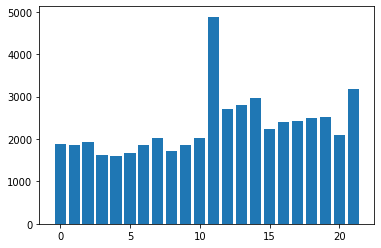

In [ ]:
plt.bar(sales_month['月ブロック'], sales_month['売上個数'])

12月(月ブロック:11)の売上個数が非常に多い傾向にあることがわかる。

# 3. 前処理

### 月ごとの売上を集計する(「商品ID」×「店舗ID」)

ここからは、モデルの学習を行うためのデータセットの作成作業に入る。<br>
『各店舗』×『各商品』の組み合わせについて、『2019年12月の1ヶ月間』における『合計売上個数』を予測する<br>
というのが今回のタスクであるため、学習用データをそれに従って再構成する。

In [ ]:
# 「月ブロック」「商品ID」「店舗ID」でグルーピングし、売上個数の合計を取る
gp_month = sales.groupby(['月ブロック',  '商品ID', '店舗ID']).agg({'売上個数': np.sum}).reset_index()
gp_month

,月ブロック,商品ID,店舗ID,売上個数
0,0,1000001,0,6.0
1,0,1000001,1,2.0
2,0,1000001,2,1.0
3,0,1000001,3,2.0
4,0,1000001,5,2.0
...,...,...,...,...
25402,21,3400003,13,2.0
25403,21,3400003,17,2.0
25404,21,3500001,0,1.0
25405,21,3500001,4,2.0


### 「'月'、'商品ID'、 '店舗ID'」の全組み合わせを作成する

salesデータには、売上が0個の場合の履歴が含まれていない。<br>
そのため、モデルに『売上が0個となる』場合を正しく学習させるには、新たにデータを生成する必要がある。<br>
ここでは、「月」×「商品ID」×「店舗ID」の組み合わせを生成し、元のデータと統合することで、『売上が0個となる』場合も含めた売上履歴データの生成を試みる。

In [ ]:
all_combination = []

# '月'、'商品ID'、 '店舗ID'の全組み合わせを作成する
columns = ['月ブロック', '商品ID', '店舗ID']

for i in range(22):
    train_block = sales[sales['月ブロック']==i]
    all_combination.append(np.array(list(product([i], sales['商品ID'].unique(), sales['店舗ID'].unique()))))
    
all_combination = pd.DataFrame(np.vstack(all_combination), columns=columns)
all_combination.sort_values(columns, inplace=True)

print(all_combination.info())
all_combination

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67320 entries, 3 to 66165
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   月ブロック   67320 non-null  int64
 1   商品ID    67320 non-null  int64
 2   店舗ID    67320 non-null  int64
dtypes: int64(3)
memory usage: 2.1 MB
None


,月ブロック,商品ID,店舗ID
3,0,1000001,0
5,0,1000001,1
10,0,1000001,2
17,0,1000001,3
14,0,1000001,4
...,...,...,...
66156,21,3500001,13
66157,21,3500001,14
66154,21,3500001,15
66159,21,3500001,16


In [ ]:
# all_combinationに売上履歴データを追加する
all_train = pd.merge(all_combination, gp_month, on=['月ブロック', '商品ID', '店舗ID'], how='left')

# 売上個数がNaNとなっている箇所は、売上個数0個として値を埋める
all_train['売上個数'] = all_train['売上個数'].fillna(0)

all_train

,月ブロック,商品ID,店舗ID,売上個数
0,0,1000001,0,6.0
1,0,1000001,1,2.0
2,0,1000001,2,1.0
3,0,1000001,3,2.0
4,0,1000001,4,0.0
...,...,...,...,...
67315,21,3500001,13,2.0
67316,21,3500001,14,0.0
67317,21,3500001,15,0.0
67318,21,3500001,16,0.0


### testデータにカラムを追加する

In [ ]:
new_test = test.copy()

# 評価対象期間が2019年12月(月ブロック: 23)であるという情報を追加
new_test['月ブロック'] = 23

new_test.head()

,商品ID,店舗ID,月ブロック
index,,,
0,1000001,0,23
1,1000001,1,23
2,1000001,2,23
3,1000001,3,23
4,1000001,4,23


### 学習データとテストデータを縦に結合: pd.concat()

In [ ]:
dataset = pd.concat([all_train, new_test])
dataset

,月ブロック,商品ID,店舗ID,売上個数
0,0,1000001,0,6.0
1,0,1000001,1,2.0
2,0,1000001,2,1.0
3,0,1000001,3,2.0
4,0,1000001,4,0.0
...,...,...,...,...
3055,23,3500001,13,NaN
3056,23,3500001,14,NaN
3057,23,3500001,15,NaN
3058,23,3500001,16,NaN


予測対象である月ブロック23(2019年12月)における売上履歴は当然存在しないため値はNaNとなる

# 4. 特徴量生成
- <font color="#FF0000"><strong>【ポイント】予測モデルの精度向上の為には適切な特徴量を追加することが一つのポイントとなりますので、どんな特徴量を作るべきかを検討しましょう</strong></font>
- こちらでは１年前の売上というラグ特徴量を紹介しています

### ラグ特徴量の作成

昨年度同月の売上個数が今年度の売上個数の予測に役立つのではないかという仮説のもとに、ラグ特徴量を生成する<br>
ここでは、月ブロックを1年分(12)ずらした上でデータを統合するという方法を取る。

In [ ]:
dataset2 = dataset
for i in range(1,13):
  lag = dataset.copy()   
  lag['月ブロック'] = lag['月ブロック'] + i
  lag = lag.rename(columns={'売上個数': str(i)+'ヶ月前の売上個数'})
  dataset2 = pd.merge(dataset2, lag, on=['月ブロック', '商品ID', '店舗ID'], how='left', left_index=True)


In [ ]:
dataset2

,月ブロック,商品ID,店舗ID,売上個数,1ヶ月前の売上個数,2ヶ月前の売上個数,3ヶ月前の売上個数,4ヶ月前の売上個数,5ヶ月前の売上個数,6ヶ月前の売上個数,7ヶ月前の売上個数,8ヶ月前の売上個数,9ヶ月前の売上個数,10ヶ月前の売上個数,11ヶ月前の売上個数,12ヶ月前の売上個数
NaN,0,1000001,0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaN,0,1000001,1,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaN,0,1000001,2,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaN,0,1000001,3,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaN,0,1000001,4,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36715.0,23,3500001,13,NaN,NaN,2.0,3.0,1.0,1.0,1.0,2.0,0.0,1.0,2.0,0.0,3.0
36716.0,23,3500001,14,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36717.0,23,3500001,15,NaN,NaN,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
36718.0,23,3500001,16,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
print(dataset2.groupby('月ブロック').agg({'9ヶ月前の売上個数': 'count'}))

       9ヶ月前の売上個数
月ブロック           
0              0
1              0
2              0
3              0
4              0
5              0
6              0
7              0
8              0
9           3060
10          3060
11          3060
12          3060
13          3060
14          3060
15          3060
16          3060
17          3060
18          3060
19          3060
20          3060
21          3060
23          3060


### ラグ特徴量の追加

↑ 「月ブロック」0〜11のデータに該当するデータは、12ヶ月前の売上履歴が存在しないので、カラム「12ヶ月前の売上個数」すべて欠損値となる

### 「商品カテゴリ」「年・月」情報の追加

In [ ]:
dataset3 = pd.merge(dataset2, cats, on='商品ID', how='left')
dataset3 = pd.merge(dataset3, cat_names, on='商品カテゴリID', how='left')
dataset3 = pd.merge(dataset3, gp_time, on='月ブロック', how='left')

print(dataset3.info())
dataset3.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70380 entries, 0 to 70379
Data columns (total 21 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   月ブロック       70380 non-null  int64  
 1   商品ID        70380 non-null  int64  
 2   店舗ID        70380 non-null  int64  
 3   売上個数        67320 non-null  float64
 4   1ヶ月前の売上個数   64260 non-null  float64
 5   2ヶ月前の売上個数   64260 non-null  float64
 6   3ヶ月前の売上個数   61200 non-null  float64
 7   4ヶ月前の売上個数   58140 non-null  float64
 8   5ヶ月前の売上個数   55080 non-null  float64
 9   6ヶ月前の売上個数   52020 non-null  float64
 10  7ヶ月前の売上個数   48960 non-null  float64
 11  8ヶ月前の売上個数   45900 non-null  float64
 12  9ヶ月前の売上個数   42840 non-null  float64
 13  10ヶ月前の売上個数  39780 non-null  float64
 14  11ヶ月前の売上個数  36720 non-null  float64
 15  12ヶ月前の売上個数  33660 non-null  float64
 16  商品カテゴリID    70380 non-null  int64  
 17  商品大カテゴリ     70380 non-null  object 
 18  商品小カテゴリ     70380 non-null  object 
 19  年           70380 non-nul

,月ブロック,商品ID,店舗ID,売上個数,1ヶ月前の売上個数,2ヶ月前の売上個数,3ヶ月前の売上個数,4ヶ月前の売上個数,5ヶ月前の売上個数,6ヶ月前の売上個数,7ヶ月前の売上個数,8ヶ月前の売上個数,9ヶ月前の売上個数,10ヶ月前の売上個数,11ヶ月前の売上個数,12ヶ月前の売上個数,商品カテゴリID,商品大カテゴリ,商品小カテゴリ,年,月
0,0,1000001,0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100,映画,DVD,2018,01
1,0,1000001,1,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100,映画,DVD,2018,01
2,0,1000001,2,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100,映画,DVD,2018,01
3,0,1000001,3,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100,映画,DVD,2018,01
4,0,1000001,4,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100,映画,DVD,2018,01


### 文字列データを数値データに直す: pandas.Series.astype()

In [ ]:
dataset3['年'] = dataset3['年'].astype(int)
dataset3['月'] = dataset3['月'].astype(int)

In [ ]:
dataset3['商品カテゴリID'] = dataset3['商品カテゴリID'].astype(str)


In [ ]:
dataset3.dtypes

月ブロック           int64
商品ID            int64
店舗ID            int64
売上個数          float64
1ヶ月前の売上個数     float64
2ヶ月前の売上個数     float64
3ヶ月前の売上個数     float64
4ヶ月前の売上個数     float64
5ヶ月前の売上個数     float64
6ヶ月前の売上個数     float64
7ヶ月前の売上個数     float64
8ヶ月前の売上個数     float64
9ヶ月前の売上個数     float64
10ヶ月前の売上個数    float64
11ヶ月前の売上個数    float64
12ヶ月前の売上個数    float64
商品カテゴリID       object
商品大カテゴリ        object
商品小カテゴリ        object
年               int64
月               int64
dtype: object

In [ ]:
!pip install category_encoders
import category_encoders as ce

     |████████████████████████████████| 80 kB 4.2 MB/s 


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
list_cols = ['商品カテゴリID','商品大カテゴリ','商品小カテゴリ']
count_encorder = ce.CountEncoder(cols=list_cols,handle_unknown='impute')
enc_dataset3 = count_encorder.fit_transform(dataset3)

enc_dataset3.head()

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,月ブロック,商品ID,店舗ID,売上個数,1ヶ月前の売上個数,2ヶ月前の売上個数,3ヶ月前の売上個数,4ヶ月前の売上個数,5ヶ月前の売上個数,6ヶ月前の売上個数,7ヶ月前の売上個数,8ヶ月前の売上個数,9ヶ月前の売上個数,10ヶ月前の売上個数,11ヶ月前の売上個数,12ヶ月前の売上個数,商品カテゴリID,商品大カテゴリ,商品小カテゴリ,年,月
0,0,1000001,0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6210,11178,6210,2018,1
1,0,1000001,1,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6210,11178,6210,2018,1
2,0,1000001,2,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6210,11178,6210,2018,1
3,0,1000001,3,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6210,11178,6210,2018,1
4,0,1000001,4,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6210,11178,6210,2018,1


In [ ]:
enc_dataset3['商品小カテゴリ'].unique()

array([ 6210,   828, 17388,  2070,  1242,  7866,  2898,  1656,  3726,
        2484,   414])

In [ ]:
dataset3 = enc_dataset3.copy()

## データセットの整理

### データセットを学習用とテスト用に分割する

In [ ]:
# 学習データとしては、「12ヶ月前の売上個数」カラムが存在するレコードのみを抽出する
train_dataset = dataset3[(dataset3['月ブロック'] >= 12) & (dataset3['月ブロック'] != 23)]

test_dataset = dataset3[dataset3['月ブロック'] == 23]

In [ ]:
test_dataset.fillna(-1,inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4327: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [ ]:
train_dataset

,月ブロック,商品ID,店舗ID,売上個数,1ヶ月前の売上個数,2ヶ月前の売上個数,3ヶ月前の売上個数,4ヶ月前の売上個数,5ヶ月前の売上個数,6ヶ月前の売上個数,7ヶ月前の売上個数,8ヶ月前の売上個数,9ヶ月前の売上個数,10ヶ月前の売上個数,11ヶ月前の売上個数,12ヶ月前の売上個数,商品カテゴリID,商品大カテゴリ,商品小カテゴリ,年,月
36720,12,1000001,0,2.0,0.0,2.0,0.0,1.0,2.0,3.0,4.0,0.0,2.0,1.0,3.0,6.0,6210,11178,6210,2019,1
36721,12,1000001,1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,2.0,0.0,2.0,0.0,1.0,2.0,6210,11178,6210,2019,1
36722,12,1000001,2,0.0,0.0,1.0,1.0,2.0,4.0,3.0,2.0,1.0,0.0,1.0,0.0,1.0,6210,11178,6210,2019,1
36723,12,1000001,3,5.0,9.0,7.0,7.0,9.0,6.0,4.0,1.0,2.0,8.0,3.0,0.0,2.0,6210,11178,6210,2019,1
36724,12,1000001,4,4.0,7.0,5.0,6.0,2.0,2.0,6.0,4.0,2.0,2.0,1.0,2.0,0.0,6210,11178,6210,2019,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67315,21,3500001,13,2.0,3.0,1.0,1.0,1.0,2.0,0.0,1.0,2.0,0.0,3.0,1.0,2.0,414,4968,414,2019,10
67316,21,3500001,14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,414,4968,414,2019,10
67317,21,3500001,15,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,414,4968,414,2019,10
67318,21,3500001,16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,414,4968,414,2019,10


In [ ]:
test_dataset

,月ブロック,商品ID,店舗ID,売上個数,1ヶ月前の売上個数,2ヶ月前の売上個数,3ヶ月前の売上個数,4ヶ月前の売上個数,5ヶ月前の売上個数,6ヶ月前の売上個数,7ヶ月前の売上個数,8ヶ月前の売上個数,9ヶ月前の売上個数,10ヶ月前の売上個数,11ヶ月前の売上個数,12ヶ月前の売上個数,商品カテゴリID,商品大カテゴリ,商品小カテゴリ,年,月
67320,23,1000001,0,-1.0,-1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,6210,11178,6210,2019,12
67321,23,1000001,1,-1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6210,11178,6210,2019,12
67322,23,1000001,2,-1.0,-1.0,2.0,0.0,3.0,0.0,2.0,0.0,1.0,1.0,2.0,0.0,0.0,6210,11178,6210,2019,12
67323,23,1000001,3,-1.0,-1.0,2.0,3.0,6.0,5.0,4.0,5.0,2.0,3.0,2.0,5.0,9.0,6210,11178,6210,2019,12
67324,23,1000001,4,-1.0,-1.0,12.0,8.0,14.0,9.0,6.0,5.0,3.0,6.0,8.0,4.0,7.0,6210,11178,6210,2019,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70375,23,3500001,13,-1.0,-1.0,2.0,3.0,1.0,1.0,1.0,2.0,0.0,1.0,2.0,0.0,3.0,414,4968,414,2019,12
70376,23,3500001,14,-1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,414,4968,414,2019,12
70377,23,3500001,15,-1.0,-1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,414,4968,414,2019,12
70378,23,3500001,16,-1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,414,4968,414,2019,12


### データセットを入力値、目標値に分割

In [ ]:
X_train = train_dataset.drop('売上個数', axis=1)
y_train = train_dataset['売上個数']

X_test = test_dataset.drop(['売上個数'], axis=1)

# 5. モデリング
- <font color="#FF0000"><strong>【ポイント】利用するモデルによっても予測精度は変わります。様々なモデル×パラメータチューニングを試してみましょう。</strong></font>
- ここでは、特徴量の正規化などは行わずに単純な重回帰モデルによる学習・予測を行った場合の例を示す。

In [ ]:
# モデルインスタンスの生成
model = LinearRegression()

# モデルの学習
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
# 学習済みのモデルを使用してテストデータに関する予測値を算出する
y_pred_lin = model.predict(X_test)

In [ ]:
from lightgbm import LGBMRegressor

In [ ]:
  clf = LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.7,
                                importance_type='split', learning_rate=0.05, max_depth=-1,
                                min_child_samples=10, min_child_weight=0.001, min_split_gain=0.0,
                                n_estimators=9999, n_jobs=-1, num_leaves=15, objective='regression',
                                random_state=71, reg_alpha=0.0, reg_lambda=0.0, silent=True,
                                subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
  

clf.fit(X_train, y_train)
y_pred_lgb = clf.predict(X_test)

In [ ]:
y_pred_lgb

array([ 0.04214238,  0.23267382,  1.80110197, ..., -0.00375237,
       -0.08259419, -0.02023198])

In [ ]:
y_pred_lin

array([ 0.19607671,  0.04038149,  0.27339891, ..., -0.21211651,
       -0.23256549, -0.2054039 ])

In [ ]:
y_pred = (y_pred_lgb+y_pred_lin)/2
y_pred

array([ 0.11910954,  0.13652766,  1.03725044, ..., -0.10793444,
       -0.15757984, -0.11281794])

In [ ]:
y_pred_round = np.round(y_pred)

In [ ]:
y_pred_round

array([ 0.,  0.,  1., ..., -0., -0., -0.])

# 6. 提出用ファイルの作成: pandas.DataFrame.to_csv()

sample_submission.csvを元に、提出用ファイルを作成する

In [ ]:
# sample_submissionの中身を確認
sub.head()

,0,1
0,0,100
1,1,100
2,2,100
3,3,100
4,4,100


In [ ]:
# sample_submissionの右側のカラムに予測値を代入する。
sub.iloc[:, -1] = y_pred_lgb

sub

,0,1
0,0,0.042142
1,1,0.232674
2,2,1.801102
3,3,1.620232
4,4,3.824412
...,...,...
3055,3055,0.833681
3056,3056,-0.048235
3057,3057,-0.003752
3058,3058,-0.082594


In [ ]:
# 予測ファイルの生成
sub.to_csv('my_submission_lgb.csv', index=False, header=False)